# Quantifying the effect of inefficiencies in a Road Network : NYC
#### - Akshay Penmatcha / akp418

In [132]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import fiona
from fiona.crs import from_epsg
import shapely
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from sklearn import cluster, datasets
import matplotlib.pylab as plt
#from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
%matplotlib inline

%matplotlib inline

In [2]:
# Dataset_1: Importing the Streetline Datafile

nyc_streetline = gpd.read_file('Data/Streetline/geo_export_bd3fc424-f8ad-4c3b-9d41-362af6349e2e.shp')
nyc_streetline.head()

,bike_lane,borocode,date_creat,date_modif,frm_lvl_co,full_stree,geometry,l_blkfc_id,l_high_hn,l_low_hn,...,rw_type,shape_leng,snow_pri,st_name,st_width,status,time_creat,time_modif,to_lvl_co,trafdir
0,None,4,2007-11-29,2015-11-03,13.0,133 AVE,LINESTRING (-73.7909965719556 40.6685376109849...,4.226098e+07,148-099,148-001,...,1.0,247.574169,T,133 AV,30.0,2,00:00:00.000,00:00:00.000,13.0,TW
1,None,4,2009-06-16,2015-11-07,13.0,GCP,LINESTRING (-73.84554250435114 40.739657802135...,9.226099e+07,None,None,...,2.0,650.954853,P,GRAND CENTRAL PKWY,45.0,2,00:00:00.000,00:00:00.000,13.0,FT
2,None,3,2007-11-29,2016-02-05,13.0,WASHINGTON AVE,LINESTRING (-73.96582204725706 40.688209422824...,1.922614e+09,393,349,...,1.0,540.018331,P,WASHINGTON AV,40.0,2,00:00:00.000,00:00:00.000,13.0,TW
3,2,4,2015-07-06,2015-09-23,13.0,ROCKAWAY BEACH AVE,LINESTRING (-73.85196038837651 40.574280057286...,1.226127e+07,134-099,134-001,...,1.0,251.080202,P,ROCKAWAY BEACH BLVD,24.0,2,00:00:00.000,00:00:00.000,13.0,TF
4,None,4,2007-11-29,2015-11-07,13.0,94 ST,LINESTRING (-73.86924838521583 40.740570212006...,9.226385e+07,51-099,51-001,...,1.0,260.488194,P,94 ST,30.0,2,00:00:00.000,00:00:00.000,13.0,TW


In [3]:
# Dataset_1: Changing the Co-ordinate system for Uniformity
nyc_streetline.crs = from_epsg(4326)
nyc_streetline.to_crs(epsg=4326, inplace=True)

In [58]:
# Dataset_1 : Filtering and Cleaning Unnecessary Data
nyc_streetline = nyc_streetline[[ u'physicalid', u'geometry', u'st_width', u'shape_leng', u'bike_lane', 
                                 u'borocode', u'l_zip', u'rw_type' ]]

mn_streetline = nyc_streetline[nyc_streetline.borocode == '1']
mn_streetline = mn_streetline[mn_streetline.rw_type == 1]
mn_streetline = mn_streetline[mn_streetline.st_width != 0]

#Resetting Index after clean
mn_streetline.reset_index(inplace=True)
mn_streetline.drop('index', axis=1, inplace=True)

#Renaming Columns after reset
mn_streetline.columns = ['physicalid', 'geometry', 'Street_width_1', 'Shape_length_1', 'bike_lane_1',  u'borocode',\
                         u'l_zip', u'rw_type']
mn_streetline.drop(['borocode', 'l_zip', 'rw_type'],axis=1, inplace=True)
mn_streetline.head()

,physicalid,geometry,Street_width_1,Shape_length_1,bike_lane_1
0,756.0,LINESTRING (-74.0082589089775 40.7446738428873...,44.0,54.871697,4
1,23368.0,LINESTRING (-73.96269457607582 40.760746052436...,30.0,375.239267,None
2,4357.0,LINESTRING (-73.98391366493104 40.711303332442...,26.0,83.302336,None
3,2901.0,LINESTRING (-73.94778083851676 40.830263780459...,40.0,259.939595,None
4,26755.0,LINESTRING (-73.93547108195284 40.849144383074...,42.0,289.503483,None


In [5]:
# Dataset_1 : Truncated Version for running the code
x_streetline = mn_streetline.loc[:100,:]
x_streetline.head()

,geometry,Street_width_1,Shape_length_1,bike_lane_1
0,LINESTRING (-74.0082589089775 40.7446738428873...,44.0,54.871697,4
1,LINESTRING (-73.96269457607582 40.760746052436...,30.0,375.239267,None
2,LINESTRING (-73.98391366493104 40.711303332442...,26.0,83.302336,None
3,LINESTRING (-73.94778083851676 40.830263780459...,40.0,259.939595,None
4,LINESTRING (-73.93547108195284 40.849144383074...,42.0,289.503483,None


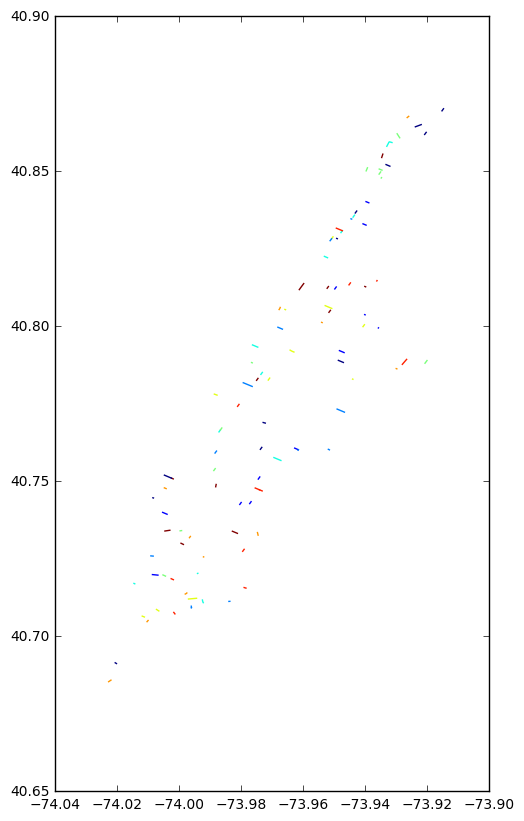

In [6]:
# Dataset_1 : Sample Plotting of Truncated Data
x_streetline.plot(figsize=(10,10))
plt.show()

In [7]:
# Dataset_2: Importing the Potholes Shape File Data (Sourced from Open Data - refered by Varun)

nyc_pthls = gpd.read_file("Data/closed-potholes-datafeeds/ClosedPotholes_201608161516.shp")
nyc_pthls.head()

,Boro,DefNum,FrmPrimNam,HouseNum,InitBy,OBJECTID,OFT,OnFaceName,OnPrimName,RptClosed,RptDate,Shape_leng,Source,SpecLoc,ToPrimName,geometry
0,B,DB2004287021,BELT PARKWAY,None,CSC,1,318630377030377030,BEDFORD AV,BEDFORD AVENUE,2013-02-14,2004-10-13,217.321398,CTZ,SB ON BEDFORD_UNDERNEATH OVERPASS,BELT PARKWAY,LINESTRING (999841.5793691427 152521.396450728...
1,B,DB2006085009,38 STREET,None,CSC,2,306380308480308530,13 AV,13 AVENUE,2014-10-11,2006-03-26,260.495098,CTZ,I/F/O B16 BUS STOP,39 STREET,LINESTRING (988216.0878563821 172877.916761219...
2,B,DB2007166005,LEWIS AVENUE,1688,CSC,3,342730355530375430,FULTON ST,FULTON STREET,2011-01-14,2007-06-15,549.255973,CTZ,POTHOLE NEAR CURB I/F/O ADDRESS,SCHENECTADY AVENUE,LINESTRING (1002314.241746634 186877.218815058...
3,B,DB2009352004,DEKALB AVENUE,45,CSC,4,380030331530342730,ST FELIX ST,ST FELIX STREET,2010-01-06,2009-12-18,836.436669,CTZ,"4"" DEEP",FULTON STREET,LINESTRING (990367.9142613858 190592.204823389...
4,B,DB2009362038,EAST 5 STREET,514,CSC,5,313830335030367730,AV C,AVENUE C,2010-01-04,2009-12-28,385.456668,CTZ,ONE POTHOLE I/F/O DRIVE WAY RIGHT OFF THE CURB,OCEAN PARKWAY,LINESTRING (991183.998259142 172724.2225148082...


In [8]:
# Dataset_2: Changing the Co-ordinate system for Uniformity
nyc_pthls.crs = from_epsg(2263)
nyc_pthls.to_crs(epsg=4326, inplace=True)
nyc_pthls.head()

,Boro,DefNum,FrmPrimNam,HouseNum,InitBy,OBJECTID,OFT,OnFaceName,OnPrimName,RptClosed,RptDate,Shape_leng,Source,SpecLoc,ToPrimName,geometry
0,B,DB2004287021,BELT PARKWAY,None,CSC,1,318630377030377030,BEDFORD AV,BEDFORD AVENUE,2013-02-14,2004-10-13,217.321398,CTZ,SB ON BEDFORD_UNDERNEATH OVERPASS,BELT PARKWAY,LINESTRING (-73.94386629059676 40.585298362137...
1,B,DB2006085009,38 STREET,None,CSC,2,306380308480308530,13 AV,13 AVENUE,2014-10-11,2006-03-26,260.495098,CTZ,I/F/O B16 BUS STOP,39 STREET,LINESTRING (-73.98570910180842 40.641185633551...
2,B,DB2007166005,LEWIS AVENUE,1688,CSC,3,342730355530375430,FULTON ST,FULTON STREET,2011-01-14,2007-06-15,549.255973,CTZ,POTHOLE NEAR CURB I/F/O ADDRESS,SCHENECTADY AVENUE,LINESTRING (-73.93487210852417 40.679593087752...
3,B,DB2009352004,DEKALB AVENUE,45,CSC,4,380030331530342730,ST FELIX ST,ST FELIX STREET,2010-01-06,2009-12-18,836.436669,CTZ,"4"" DEEP",FULTON STREET,LINESTRING (-73.97793940872548 40.689806193405...
4,B,DB2009362038,EAST 5 STREET,514,CSC,5,313830335030367730,AV C,AVENUE C,2010-01-04,2009-12-28,385.456668,CTZ,ONE POTHOLE I/F/O DRIVE WAY RIGHT OFF THE CURB,OCEAN PARKWAY,LINESTRING (-73.9750150681262 40.6407619495311...


In [9]:
# Dataset_2: Filtering and Cleaning Unnecessary Data

# Truncating the initial datset to consider only Manhattan
mn_pthls = nyc_pthls[nyc_pthls['Boro'] == 'M']
mn_pthls.reset_index(inplace=True)
mn_pthls.drop('index', axis=1, inplace=True)
mn_pthls = gpd.GeoDataFrame(mn_pthls[['geometry','DefNum']])
mn_pthls.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,geometry,DefNum
0,LINESTRING (-73.99363904952871 40.727289211243...,DM1995139014
1,LINESTRING (-73.96091016170175 40.780857035824...,DM1997251001
2,(LINESTRING (-73.99373479457627 40.72091647931...,DM2009365001
3,LINESTRING (-73.98085965460861 40.741969767614...,DM2009365002
4,LINESTRING (-73.99190572913157 40.716203020802...,DM2009365008


In [10]:
mn_pthls.crs = from_epsg(4326)
mn_pthls.crs

{'init': 'epsg:4326', 'no_defs': True}

In [11]:
# Dataset_2 : Truncated Version for running the code

x_pthls = mn_pthls.loc[:100,:]
x_pthls.head()

,geometry,DefNum
0,LINESTRING (-73.99363904952871 40.727289211243...,DM1995139014
1,LINESTRING (-73.96091016170175 40.780857035824...,DM1997251001
2,(LINESTRING (-73.99373479457627 40.72091647931...,DM2009365001
3,LINESTRING (-73.98085965460861 40.741969767614...,DM2009365002
4,LINESTRING (-73.99190572913157 40.716203020802...,DM2009365008


In [12]:
# Dataset_2: Trying to group the No: of Potholes per Linestring

x_pthls_count = gpd.GeoDataFrame(x_pthls.geometry.value_counts())
x_pthls_count.reset_index(inplace=True)
x_pthls_count.columns = ['geometry','Potholes']
x_pthls_count.head()

,geometry,Potholes
0,LINESTRING (-73.94832657203315 40.808972274104...,2
1,LINESTRING (-73.95918180056893 40.771696823367...,2
2,LINESTRING (-73.94226311105818 40.806415737867...,2
3,LINESTRING (-73.94711812794634 40.771712791877...,2
4,LINESTRING (-73.96297460261326 40.762487076337...,2


In [13]:
# Dataset_2: Changing the Co-ordinate system for Uniformity
x_pthls_count.crs = from_epsg(4326)
x_pthls_count.head()

,geometry,Potholes
0,LINESTRING (-73.94832657203315 40.808972274104...,2
1,LINESTRING (-73.95918180056893 40.771696823367...,2
2,LINESTRING (-73.94226311105818 40.806415737867...,2
3,LINESTRING (-73.94711812794634 40.771712791877...,2
4,LINESTRING (-73.96297460261326 40.762487076337...,2


In [14]:
# Dataset_3 : Traffic Volume (Sourced from Open Data - AD)

# Cleaned in Local System due to compute errors and uploaded clean data here
nyc_traf_vol = gpd.read_file('Data/Traffic_Volume/Traffic_Volume.shp')
nyc_traf_vol.head()

,AADT,ROADWAYTYP,Shape_Leng,geometry
0,6052.0,Road,1166.162041,LINESTRING (-73.85312405872757 40.894913023868...
1,10157.0,Road,5308.008397,LINESTRING (-73.86787494280257 40.858515042894...
2,24026.0,Road,627.653516,LINESTRING (-73.86787601871585 40.850005988139...
3,4125.0,Road,658.237350,LINESTRING (-73.86076395786807 40.866725988183...
4,7710.0,Road,885.373971,LINESTRING (-73.93014202869557 40.819212013064...


In [15]:
# Dataset_3 : Rearranging the dataset and Filtering for convenience

nyc_traf_vol = nyc_traf_vol[['geometry', 'AADT', 'Shape_Leng']]
nyc_traf_vol.columns = ['geometry', 'Traf_Vol_3', 'Shape_Length_3']
nyc_traf_vol.head()

,geometry,Traf_Vol_3,Shape_Length_3
0,LINESTRING (-73.85312405872757 40.894913023868...,6052.0,1166.162041
1,LINESTRING (-73.86787494280257 40.858515042894...,10157.0,5308.008397
2,LINESTRING (-73.86787601871585 40.850005988139...,24026.0,627.653516
3,LINESTRING (-73.86076395786807 40.866725988183...,4125.0,658.237350
4,LINESTRING (-73.93014202869557 40.819212013064...,7710.0,885.373971


In [16]:
# Dataset_3 :  Changing the Co-ordinate system for Uniformity
nyc_traf_vol.crs = from_epsg(4326)
nyc_traf_vol.head()

,geometry,Traf_Vol_3,Shape_Length_3
0,LINESTRING (-73.85312405872757 40.894913023868...,6052.0,1166.162041
1,LINESTRING (-73.86787494280257 40.858515042894...,10157.0,5308.008397
2,LINESTRING (-73.86787601871585 40.850005988139...,24026.0,627.653516
3,LINESTRING (-73.86076395786807 40.866725988183...,4125.0,658.237350
4,LINESTRING (-73.93014202869557 40.819212013064...,7710.0,885.373971


In [17]:
# Dataset_4 : MTA Bus Stops (Sourced from Open Data - VI)

nyc_busstops = gpd.read_file('Data/Bus_Shapefiles/BusStopsAsOfMarch2.shp')
nyc_busstops.head()

,box_id,geometry,name,zip_name
0,100646,POINT (-73.878334 40.84256),BOSTON RD/E 180 ST,2016Jan_Prod_r03_b6
1,103374,POINT (-73.840965 40.828102),BRUSH AV/BRUCKNER BL,2016Jan_Prod_r03_b6
2,103379,POINT (-73.856995 40.8325),CROSS BX SVC RD/NEWBOLD AV,2016Jan_Prod_r03_b6
3,103380,POINT (-73.866432 40.835388),CROSS BX SVC RD/TAYLOR AV,2016Jan_Prod_r03_b6
4,103381,POINT (-73.870407 40.836433),CROSS BX SVC RD/COMMONWEALTH AV,2016Jan_Prod_r03_b6


In [18]:
# Dataset_4 : Filtering and Cleaning Unnecessary Data

nyc_busstops = nyc_busstops[['geometry','box_id']]
nyc_busstops.head()

,geometry,box_id
0,POINT (-73.878334 40.84256),100646
1,POINT (-73.840965 40.828102),103374
2,POINT (-73.856995 40.8325),103379
3,POINT (-73.866432 40.835388),103380
4,POINT (-73.870407 40.836433),103381


In [19]:
#Dataset_4 : Checking the Coordinate System
nyc_busstops.crs

{'init': u'epsg:4326'}

In [20]:
# Dataset_5: Zip Code Level Data (Sourced from Open Data - VI)

nyc_zips = gpd.read_file('Data/ZIP_CODE_040114/ZIP_CODE_040114.shp')
nyc_zips.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [21]:
# Dataset_5 : Filtering and Cleaning Unnecessary Data
nyc_zips = nyc_zips[['geometry', 'ZIPCODE']]
nyc_zips.head()

,geometry,ZIPCODE
0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436
1,"POLYGON ((1001613.712964058 186926.4395172149,...",11213
2,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212
3,"POLYGON ((995908.3654508889 183617.6128015518,...",11225
4,"POLYGON ((991997.1134308875 176307.4958601296,...",11218


In [22]:
# Dataset_5 :  Changing the Co-ordinate system for Uniformity
nyc_zips.crs = from_epsg(2263)
nyc_zips.to_crs(epsg=4326, inplace=True)
nyc_zips.head()

,geometry,ZIPCODE
0,POLYGON ((-73.80584847647394 40.68290932644246...,11436
1,"POLYGON ((-73.93739763139813 40.6797295892508,...",11213
2,POLYGON ((-73.90294132545438 40.67083977590007...,11212
3,POLYGON ((-73.95797316043482 40.67065695897565...,11225
4,POLYGON ((-73.97208109564257 40.65059658727609...,11218


In [23]:
nyc_zips.crs

{'init': 'epsg:4326', 'no_defs': True}

# Selecting the Data for ZIP Code 10036

#### Explanation:

Since the Datasets are huge and need a lot of computation power, I am trying to analyse the data for one ZIP code so that
I can extrapolate this framework of analysis to other zipcodes at a later point of time.

In [24]:
# 1_Streetline Data: Spatial Join for Zipcodes Data
mn_streetline_zip = gpd.sjoin(mn_streetline, nyc_zips, how="inner", op='intersects')
mn_streetline_zip.drop('index_right',axis=1, inplace=True)
mn_streetline_zip.head()

,geometry,Street_width_1,Shape_length_1,bike_lane_1,ZIPCODE
0,LINESTRING (-74.0082589089775 40.7446738428873...,44.0,54.871697,4,10011
13,LINESTRING (-73.99918595445679 40.734138581908...,24.0,131.873912,2,10011
51,LINESTRING (-74.00416830678425 40.747689292336...,52.0,179.942626,None,10011
78,LINESTRING (-73.99663935985464 40.731856258345...,40.0,164.969509,2,10011
233,LINESTRING (-74.00252381482822 40.739752643139...,68.0,288.100357,1,10011


In [25]:
# 1_Streetline Data for 10036 Zip Code

z10036_streetline = mn_streetline_zip[mn_streetline_zip['ZIPCODE'] == '10036']
z10036_streetline.reset_index(inplace=True)
z10036_streetline.drop('index', axis=1, inplace=True)
z10036_streetline.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,geometry,Street_width_1,Shape_length_1,bike_lane_1,ZIPCODE
0,LINESTRING (-73.98839044575165 40.759164185675...,70.0,261.836375,2,10036
1,LINESTRING (-73.98225528672133 40.757387364895...,34.0,886.634328,None,10036
2,LINESTRING (-73.98504970074009 40.758573625615...,50.0,257.296959,3,10036
3,LINESTRING (-73.98744642241722 40.755372960490...,30.0,896.697044,None,10036
4,LINESTRING (-73.98839044575165 40.759164185675...,30.0,898.357543,None,10036


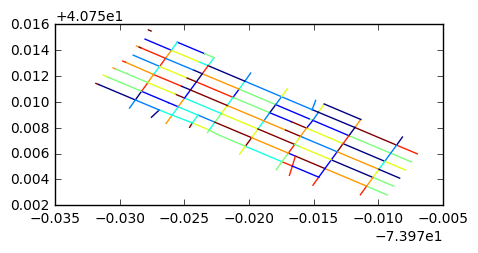

In [68]:
# z10036_Dataset_1 : Sample Plotting of Truncated Data
z10036_streetline.plot(figsize=(5,5))
plt.show()

In [26]:
# 2_Potholes Data: Spatial Join for Zipcodes Data
mn_pthls_zip = gpd.sjoin(mn_pthls, nyc_zips, how="inner", op='intersects')
mn_pthls_zip.drop('index_right',axis=1, inplace=True)
mn_pthls_zip.head()

,geometry,DefNum,ZIPCODE
0,LINESTRING (-73.99363904952871 40.727289211243...,DM1995139014,10012
2,(LINESTRING (-73.99373479457627 40.72091647931...,DM2009365001,10012
64,LINESTRING (-73.99546478567493 40.721619701739...,DM2010007010,10012
66,LINESTRING (-73.99647816655354 40.719048223742...,DM2010007012,10012
90,LINESTRING (-74.00089769870519 40.725773107416...,DM2010008018,10012


In [27]:
# 2_Potholes Data for 10036 Zip Code

z10036_pthls = mn_pthls_zip[mn_pthls_zip['ZIPCODE'] == '10036']
z10036_pthls.reset_index(inplace=True)
z10036_pthls.drop('index', axis=1, inplace=True)
z10036_pthls.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,geometry,DefNum,ZIPCODE
0,LINESTRING (-73.98929727544269 40.757906636940...,DM2010019020,10036
1,LINESTRING (-73.99360930667751 40.762183435465...,DM2010019021,10036
2,LINESTRING (-73.98461925246458 40.759199410623...,DM2010023010,10036
3,LINESTRING (-73.98510382940322 40.759404350842...,DM2010030020,10036
4,LINESTRING (-73.99307076331125 40.757827429144...,DM2010032049,10036


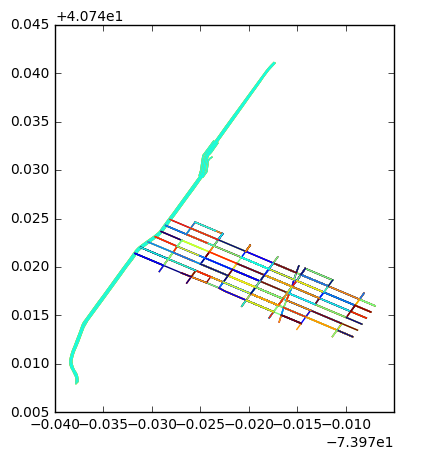

In [67]:
# z10036_Dataset_2 : Sample Plotting of Truncated Data
z10036_pthls.plot(figsize=(5,5))
plt.show()

In [39]:
z10036_pthls_count = gpd.GeoDataFrame(z10036_pthls.geometry.value_counts())
z10036_pthls_count.reset_index(inplace=True)
z10036_pthls_count.columns = ['geometry','Potholes']
z10036_pthls_count.head()

,geometry,Potholes
0,LINESTRING (-73.98694873854555 40.756035902594...,66
1,LINESTRING (-73.98179404264692 40.758021303208...,41
2,LINESTRING (-73.98792640677709 40.759790276462...,37
3,LINESTRING (-73.98744642207124 40.755372960926...,35
4,LINESTRING (-73.9897908537408 40.7572331310242...,33


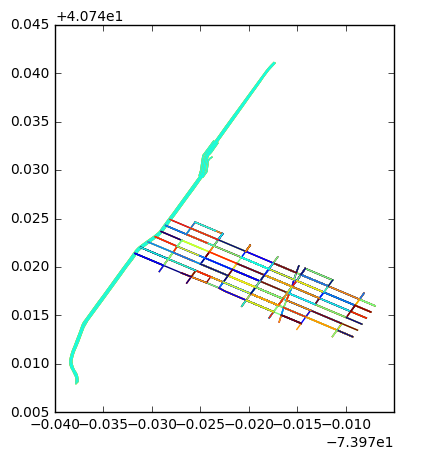

In [69]:
# z10036_Dataset_2 : Sample Plotting of Truncated Data
z10036_pthls.plot(figsize=(5,5))
plt.show()

In [28]:
# 3_Traffic Volume Data: Spatial Join for Zipcodes Data
nyc_traf_vol_zip = gpd.sjoin(nyc_traf_vol, nyc_zips, how="inner", op='intersects')
nyc_traf_vol_zip.drop('index_right',axis=1, inplace=True)
nyc_traf_vol_zip.head()

,geometry,Traf_Vol_3,Shape_Length_3,ZIPCODE
0,LINESTRING (-73.85312405872757 40.894913023868...,6052.0,1166.162041,10466
1,LINESTRING (-73.86787494280257 40.858515042894...,10157.0,5308.008397,10466
43,LINESTRING (-73.84194795621147 40.888436815236...,14172.0,917.596721,10466
74,LINESTRING (-73.86182122438159 40.894726300727...,83184.0,724.484214,10466
86,LINESTRING (-73.83579602241448 40.875971001568...,13452.0,644.594833,10466


In [29]:
# 3_Traffic Volume Data for 10036 Zip Code

z10036_traf_vol = nyc_traf_vol_zip[nyc_traf_vol_zip['ZIPCODE'] == '10036']
z10036_traf_vol.reset_index(inplace=True)
z10036_traf_vol.drop('index', axis=1, inplace=True)
z10036_traf_vol.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,geometry,Traf_Vol_3,Shape_Length_3,ZIPCODE
0,LINESTRING (-73.9942454087245 40.7582871028222...,4902.0,709.660930,10036
1,LINESTRING (-73.99482294605312 40.760216443191...,8718.0,1395.001676,10036
2,LINESTRING (-73.99346622095732 40.762132741715...,10441.0,1398.420277,10036
3,LINESTRING (-73.98167991294639 40.767619451613...,14110.0,965.434394,10036
4,(LINESTRING (-73.98638094923577 40.75581101466...,10390.0,1931.539307,10036


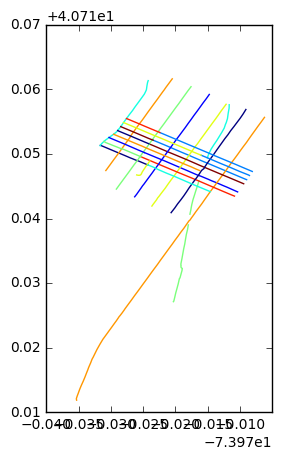

In [70]:
# z10036_Dataset_3 : Sample Plotting of Truncated Data
z10036_traf_vol.plot(figsize=(5,5))
plt.show()

In [37]:
# 4_Bus Stops Data: Spatial Join for Zipcodes Data
nyc_busstops_zip = gpd.sjoin(nyc_busstops, nyc_zips, how="inner", op='intersects')
nyc_busstops_zip.drop('index_right',axis=1, inplace=True)
nyc_busstops_zip.head()

,geometry,box_id,ZIPCODE
0,POINT (-73.878334 40.84256),100646,10460
3,POINT (-73.866432 40.835388),103380,10460
4,POINT (-73.870407 40.836433),103381,10460
14,POINT (-73.878372 40.839821),104003,10460
2124,POINT (-73.87771600000001 40.839375),904233,10460


In [35]:
nyc_busstops.crs = nyc_zips.crs

In [34]:
nyc_zips.crs

{'init': 'epsg:4326', 'no_defs': True}

In [36]:
nyc_busstops.crs

{'init': 'epsg:4326', 'no_defs': True}

In [38]:
# 4_Bus Stops Data for 10036 Zip Code

z10036_busstops = nyc_busstops_zip[nyc_busstops_zip['ZIPCODE'] == '10036']
z10036_busstops.reset_index(inplace=True)
z10036_busstops.drop('index', axis=1, inplace=True)
z10036_busstops.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,geometry,box_id,ZIPCODE
0,POINT (-73.98024700000001 40.754517),400134,10036
1,POINT (-73.97905 40.756157),400516,10036
2,POINT (-73.97996500000001 40.754871),405179,10036
3,POINT (-73.979668 40.755322),803038,10036
4,POINT (-73.983396 40.755621),450016,10036


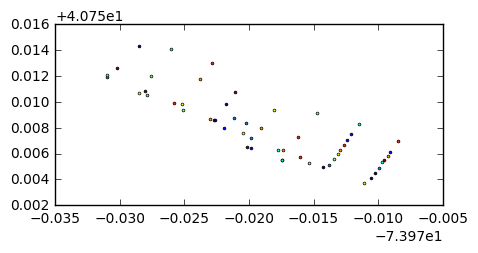

In [71]:
# z10036_Dataset_4 : Sample Plotting of Truncated Data
z10036_busstops.plot(figsize=(5,5))
plt.show()

# Final Dataset for 10036 ZIP - Trying this but lot of complexities in data merging still remain

In [45]:
z10036_pthls_count.crs = z10036_streetline.crs

In [108]:
z10036_1 = gpd.sjoin(z10036_streetline,z10036_traf_vol, how="inner", op='intersects')
len(z10036_1)

154

In [109]:
z10036_1.columns

Index([      u'geometry', u'Street_width_1', u'Shape_length_1',
          u'bike_lane_1',   u'ZIPCODE_left',    u'index_right',
           u'Traf_Vol_3', u'Shape_Length_3',  u'ZIPCODE_right'],
      dtype='object')

In [110]:
z10036_1 = z10036_1[[ u'geometry',u'Traf_Vol_3', u'Street_width_1', u'Shape_length_1', u'Shape_Length_3']]
z10036_1.sort_index(inplace=True)
z10036_1.reset_index(inplace=True)
z10036_1.drop('index', axis=1, inplace=True)
z10036_1.head()

,geometry,Traf_Vol_3,Street_width_1,Shape_length_1,Shape_Length_3
0,LINESTRING (-73.98839044575165 40.759164185675...,6444.0,70.0,261.836375,1416.269703
1,LINESTRING (-73.98225528672133 40.757387364895...,10441.0,34.0,886.634328,1398.420277
2,LINESTRING (-73.98744642241722 40.755372960490...,5753.0,30.0,896.697044,933.440515
3,LINESTRING (-73.98744642241722 40.755372960490...,29870.0,30.0,896.697044,2001.272120
4,LINESTRING (-73.98839044575165 40.759164185675...,6444.0,30.0,898.357543,1416.269703


In [126]:
#Using Normal Standardization
reg_data = pd.DataFrame()

reg_data['Traf_Vol_3'] = (z10036_1['Traf_Vol_3']-z10036_1['Traf_Vol_3'].mean())/z10036_1['Traf_Vol_3'].std()
reg_data['Street_width_1'] = (z10036_1['Street_width_1']-z10036_1['Street_width_1'].mean())/z10036_1['Street_width_1'].std()
reg_data['Shape_length_1'] = (z10036_1['Shape_length_1']-z10036_1['Shape_length_1'].mean())/z10036_1['Shape_length_1'].std()

In [127]:
reg_data.head()

,Traf_Vol_3,Street_width_1,Shape_length_1
0,-0.563767,1.415331,-0.825510
1,-0.383104,-0.873641,1.224473
2,-0.594999,-1.127971,1.257489
3,0.495079,-1.127971,1.257489
4,-0.563767,-1.127971,1.262937


In [120]:
#Feature Scaling
reg_data_1 = pd.DataFrame()
reg_data_1['Traf_Vol_3'] = (z10036_1['Traf_Vol_3']-z10036_1['Traf_Vol_3'].min())/(z10036_1['Traf_Vol_3'].max()-z10036_1['Traf_Vol_3'].min())
reg_data_1['Street_width_1'] = (z10036_1['Street_width_1']-z10036_1['Street_width_1'].min())/(z10036_1['Street_width_1'].max()-z10036_1['Street_width_1'].min())
reg_data_1['Shape_length_1'] = (z10036_1['Shape_length_1']-z10036_1['Shape_length_1'].min())/(z10036_1['Shape_length_1'].max()-z10036_1['Shape_length_1'].min())

In [121]:
reg_data_1.head()

,Traf_Vol_3,Street_width_1,Shape_length_1
0,0.022156,0.888889,0.226130
1,0.062836,0.088889,0.860750
2,0.015124,0.000000,0.870971
3,0.260574,0.000000,0.870971
4,0.022156,0.000000,0.872657


# Regression Analysis

#### Idea:

As per the initial idea, I wanted to take all the underlying factors that affect the efficiency of a road network in some way or the other and try to quantify the effect of each such factor.

#### Limitation:
Even though I have come a long way in preparing a clear dataset for analysing the efficiency of network, there are still many issues to be resolved in terms of spatial data. If u observe carefully, all of the datasets do not have the same/similar geometries, there are minor difference because of which the merge is not perfect.

Due to these limitations, (in particular for this PUI Extra Credit project) I am reducing my scope of my work to individually analyse some of the factors that are clear.

In [133]:
lm = smf.ols(formula = 'Traf_Vol_3 ~ Street_width_1 + Shape_length_1', data = reg_data).fit()
print lm.summary()
#print(lm.params[1:])
#print('R^2', lm.rsquared)

                            OLS Regression Results                            
Dep. Variable:             Traf_Vol_3   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.970
Date:                Thu, 15 Dec 2016   Prob (F-statistic):             0.0209
Time:                        20:26:10   Log-Likelihood:                -214.07
No. Observations:                 154   AIC:                             434.1
Df Residuals:                     151   BIC:                             443.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -3.469e-17      0.079  -4.39e

In [135]:
lm = smf.ols(formula = 'Traf_Vol_3 ~ Street_width_1 + Shape_length_1', data = reg_data_1).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:             Traf_Vol_3   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.970
Date:                Thu, 15 Dec 2016   Prob (F-statistic):             0.0209
Time:                        20:28:21   Log-Likelihood:                 15.531
No. Observations:                 154   AIC:                            -25.06
Df Residuals:                     151   BIC:                            -15.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          0.2470      0.055      4.

###### Despite Normalizing the accuracy of my model is very low at the moment. There is still a lot of scope to clean the data and revisit the statistics.
